# Sistema de recomendación basado en técnicas de aprendizaje no supervisado (al menos dos técnicas)


## Recomendador de Videojuegos de Steam


## Intregrantes

-Barrantes Navarro, Joshúa André COD: 22200305

-Luján Vila Frank José           COD: 12200058

-Ridoutt Quiñones Jhon Franco    COD: 22200276

-Romani Moscoso, Anthony Paolo   COD: 17200301


In [8]:
import pandas as pd

# Carga tu archivo CSV
df = pd.read_csv("steam.csv")

# Muestra las columnas disponibles
df.head()


,appid,name,release_date,english,developer,publisher,platforms,required_age,categories,genres,steamspy_tags,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price
0,10,Counter-Strike,2000-11-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,124534,3339,17612,317,10000000-20000000,7.19
1,20,Team Fortress Classic,1999-04-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,3318,633,277,62,5000000-10000000,3.99
2,30,Day of Defeat,2003-05-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Valve Anti-Cheat enabled,Action,FPS;World War II;Multiplayer,0,3416,398,187,34,5000000-10000000,3.99
3,40,Deathmatch Classic,2001-06-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,1273,267,258,184,5000000-10000000,3.99
4,50,Half-Life: Opposing Force,1999-11-01,1,Gearbox Software,Valve,windows;mac;linux,0,Single-player;Multi-player;Valve Anti-Cheat en...,Action,FPS;Action;Sci-fi,0,5250,288,624,415,5000000-10000000,3.99


In [2]:
selected_columns = [
    "name",
    "positive_ratings", "negative_ratings", "price",
    "genres", "categories", "developer", "steamspy_tags"
]
df = df[selected_columns].dropna()


In [3]:
from sklearn.preprocessing import MultiLabelBinarizer, MinMaxScaler, RobustScaler
from sklearn.compose import ColumnTransformer
import pandas as pd
import numpy as np

# ======================================================================
# CONFIGURACIÓN DE PESOS (AJUSTAR SEGÚN PRIORIDADES)
# ======================================================================
TAG_WEIGHT = 6.0       # Máximo peso para tags (lo más importante)
GENRE_WEIGHT = 1.5     # Peso intermedio para géneros
CATEGORY_WEIGHT = 0.5   # Peso menor para categorías
DEV_WEIGHT = 0.4       # Peso para características de developer
NUMERIC_WEIGHT = 1.0    # Peso para características numéricas

# ======================================================================
# PASO 1: LIMPIEZA Y PREPARACIÓN DE DATOS
# ======================================================================
def enhanced_split_and_clean(col, prefix):
    """Limpia y añade prefijos únicos a cada etiqueta"""
    return col.fillna('').apply(
        lambda x: x if isinstance(x, list) else 
        [f"{prefix}_{tag.strip().lower().replace(' ', '_')}" for tag in x.split(';') if tag.strip() != '']
    )

# Aplicar a cada tipo de característica
df['categories_list'] = enhanced_split_and_clean(df['categories'], 'cat')
df['tags_list'] = enhanced_split_and_clean(df['steamspy_tags'], 'tag')
df['genres_list'] = enhanced_split_and_clean(df['genres'], 'gen')

# ======================================================================
# PASO 2: BINARIZACIÓN DE CARACTERÍSTICAS
# ======================================================================
def safe_binarizer(series, min_occurrences=0.0001):
    """Convierte a formato one-hot eliminando etiquetas muy raras"""
    mlb = MultiLabelBinarizer()
    binary_matrix = mlb.fit_transform(series)
    
    # Filtrado dinámico basado en porcentaje
    min_count = max(int(len(series)*min_occurrences), 2)
    tag_counts = binary_matrix.sum(axis=0)
    keep_tags = tag_counts >= min_count
    
    return pd.DataFrame(
        binary_matrix[:, keep_tags],
        columns=[col for col, keep in zip(mlb.classes_, keep_tags) if keep]
    )

# Aplicar a cada categoría
categories_bin = safe_binarizer(df['categories_list'])
tags_bin = safe_binarizer(df['tags_list'])
genres_bin = safe_binarizer(df['genres_list'])

# ======================================================================
# PASO 3: PONDERACIÓN DE CARACTERÍSTICAS (ÉNFASIS EN TAGS)
# ======================================================================
def weighted_features(binary_df, base_weight=1.0, exponent=0.3):
    """
    Asigna pesos considerando:
    - base_weight: importancia del tipo de característica
    - exponent: controla el peso de características raras (menor = más énfasis)
    """
    freq = binary_df.mean(axis=0)
    weights = base_weight * (1 / (freq + 1e-6)) ** exponent
    return binary_df.multiply(weights, axis=1)

# Aplicar pesos diferenciados
tags_weighted = weighted_features(tags_bin, base_weight=TAG_WEIGHT, exponent=0.3)  # Máximo peso
genres_weighted = weighted_features(genres_bin, base_weight=GENRE_WEIGHT, exponent=0.4)
categories_weighted = weighted_features(categories_bin, base_weight=CATEGORY_WEIGHT, exponent=0.5)

# ======================================================================
# PASO 4: FEATURES NUMÉRICAS Y DE DEVELOPER
# ======================================================================
# 1. Métricas básicas (con pesos reducidos)
df['positive_ratio'] = (df['positive_ratings'] / (df['positive_ratings'] + df['negative_ratings'] + 1e-6)) * NUMERIC_WEIGHT
df['total_ratings'] = (df['positive_ratings'] + df['negative_ratings']) * NUMERIC_WEIGHT
df['price_log'] = np.log1p(df['price']) * NUMERIC_WEIGHT

# 2. Features de developer (con peso aplicado)
dev_features = df.groupby('developer').agg({
    'positive_ratio': ['mean', 'std'],
    'total_ratings': ['sum', 'mean'],
    'price_log': ['mean', 'median']
}) * DEV_WEIGHT

dev_features.columns = [f'dev_{stat[0]}_{stat[1]}' for stat in dev_features.columns]
df = df.merge(dev_features.reset_index(), on='developer', how='left')

# 3. One-hot para developers importantes (nombres normalizados)
top_devs = df['developer'].value_counts().nlargest(30).index
for dev in top_devs:
    safe_name = f"dev_{str(dev).lower().replace(' ', '_').replace('.', '')[:25]}"
    df[safe_name] = (df['developer'] == dev).astype(int) * DEV_WEIGHT

# ======================================================================
# PASO 5: CONSTRUCCIÓN DE LA MATRIZ FINAL
# ======================================================================
# 1. Unir todas las características
df_numeric = pd.concat([
    df[["positive_ratio", "price_log", "total_ratings"]],
    tags_weighted,       # Tags con mayor peso
    genres_weighted,
    categories_weighted,
    df.filter(regex='^dev_')
], axis=1)

# 2. Eliminar duplicados (por seguridad)
df_numeric = df_numeric.loc[:, ~df_numeric.columns.duplicated()]

# 3. Verificación final
print(f"Total características: {len(df_numeric.columns)}")
print(f"Tags: {len(tags_weighted.columns)}")
print(f"Géneros: {len(genres_weighted.columns)}")
print(f"Categorías: {len(categories_weighted.columns)}")

# ======================================================================
# PASO 6: NORMALIZACIÓN OPTIMIZADA
# ======================================================================
numeric_features = ["positive_ratio", "price_log", "total_ratings"]
other_features = [col for col in df_numeric.columns if col not in numeric_features]

preprocessor = ColumnTransformer([
    ('num', MinMaxScaler(), numeric_features),      # Normalización [0,1] para numéricas
    ('other', RobustScaler(), other_features)       # Estandarización robusta para el resto
], remainder='drop')

X_scaled = preprocessor.fit_transform(df_numeric)

Total características: 407
Tags: 313
Géneros: 27
Categorías: 28


In [4]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_numeric)


Epoch 1/125
106/106 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 1.8377 - learning_rate: 1.0000e-04
Epoch 2/125
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.5410 - learning_rate: 1.0000e-04
Epoch 3/125
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.3924 - learning_rate: 1.0000e-04
Epoch 4/125
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.2448 - learning_rate: 1.0000e-04
Epoch 5/125
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.2280 - learning_rate: 1.0000e-04
Epoch 6/125
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.1818 - learning_rate: 1.0000e-04
Epoch 7/125
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.1035 - learning_rate: 1.0000e-04
Epoch 8/125
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.1374 - learning_rate: 1.0000e-04
Epoch 9/125
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.1223 - learning_rate: 1.0000e-04
Epoch 10/125
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.1261 - learning_rate: 1.0000e-04
Epoch 11/125
106/106 ━━━━━━━━

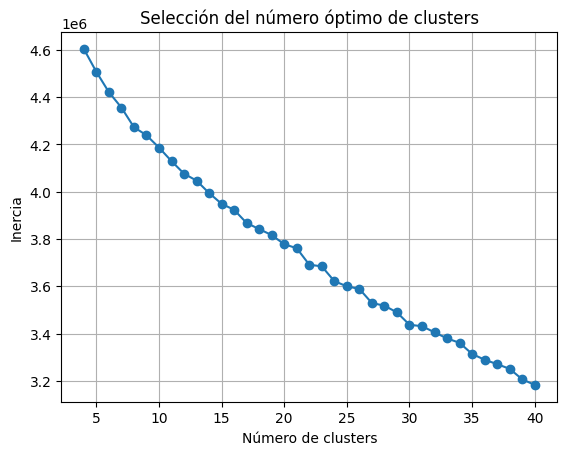


✅ Número óptimo de clusters sugerido por el método del codo: 31



In [7]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model, backend as K, callbacks
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

class ClusteringLayer(layers.Layer):
    def __init__(self, n_clusters, initial_weights=None, alpha=1.0, **kwargs):
        super(ClusteringLayer, self).__init__(**kwargs)
        self.n_clusters = n_clusters
        self.initial_weights = initial_weights
        self.alpha = alpha

    def build(self, input_shape):
        input_dim = input_shape[1]
        self.cluster_centers = self.add_weight(
            shape=(self.n_clusters, input_dim),
            initializer='glorot_uniform',
            name='cluster_centers'
        )
        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights
        self.built = True

    def call(self, inputs, **kwargs):
        q = 1.0 / (1.0 + (K.sum(K.square(K.expand_dims(inputs, axis=1) - self.cluster_centers), axis=2) / self.alpha))
        q **= (self.alpha + 1.0) / 2.0
        q = K.transpose(K.transpose(q) / K.sum(q, axis=1))
        return q

@tf.function
def target_distribution(q):
    weight = q ** 2 / tf.reduce_sum(q, axis=0)
    return (weight / tf.reduce_sum(weight, axis=1, keepdims=True)) + K.epsilon()

# 1. Preprocesamiento de datos
if np.isnan(X_scaled).any():
    imputer = SimpleImputer(strategy='mean')
    X_scaled = imputer.fit_transform(X_scaled)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_scaled)

# 2. Construir autoencoder

def build_stable_autoencoder(input_dim, encoding_dim=32):
    input_layer = layers.Input(shape=(input_dim,))
    x = layers.Dense(256, activation='relu', kernel_initializer='he_normal')(input_layer)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(128, activation='relu', kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)
    encoded = layers.Dense(encoding_dim, activation='linear', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)
    x = layers.Dense(128, activation='relu', kernel_initializer='he_normal')(encoded)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(256, activation='relu', kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)
    decoded = layers.Dense(input_dim, activation='linear')(x)
    return Model(input_layer, decoded)

# 3. Entrenar autoencoder solo una vez
autoencoder = build_stable_autoencoder(X_scaled.shape[1])
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='mse')
callbacks_list = [
    callbacks.EarlyStopping(monitor='loss', patience=10, min_delta=1e-6, restore_best_weights=True),
    callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, min_lr=1e-6)
]
autoencoder.fit(X_scaled, X_scaled, epochs=125, batch_size=256, shuffle=True, callbacks=callbacks_list, verbose=1)

# 4. Extraer encoder y codificar datos
encoder = Model(inputs=autoencoder.input, outputs=autoencoder.layers[-7].output)
X_encoded = encoder.predict(X_scaled)

# 5. Encontrar el mejor k usando KMeans

def encontrar_clusters_optimos(X_encoded, rango=(4, 40), metodo='inertia'):
    scores = []
    posibles_k = range(rango[0], rango[1] + 1)
    for k in posibles_k:
        kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
        etiquetas = kmeans.fit_predict(X_encoded)
        if metodo == 'silhouette':
            score = silhouette_score(X_encoded, etiquetas)
        elif metodo == 'inertia':
            score = kmeans.inertia_
        else:
            raise ValueError("Método no válido")
        scores.append(score)

    plt.plot(posibles_k, scores, marker='o')
    plt.xlabel('Número de clusters')
    plt.ylabel('Score' if metodo == 'silhouette' else 'Inercia')
    plt.title('Selección del número óptimo de clusters')
    plt.grid(True)
    plt.show()

    if metodo == 'silhouette':
        return posibles_k[np.argmax(scores)]
    else:
        deltas = np.diff(scores)
        return posibles_k[np.argmin(np.abs(deltas)) + 1]

k_optimo = encontrar_clusters_optimos(X_encoded)
print(f"\n✅ Número óptimo de clusters sugerido por el método del codo: {k_optimo}\n")




In [12]:
# 6. Entrenamiento DEC

def train_dec(X_scaled, encoder, X_encoded, n_clusters, maxiter=5000, update_interval=100, tol=1e-3):
    
    kmeans = KMeans(n_clusters=n_clusters, n_init=26)
    y_pred = kmeans.fit_predict(X_encoded)
    y_pred_last = y_pred.copy()

    clustering_layer = ClusteringLayer(n_clusters, initial_weights=[kmeans.cluster_centers_])(encoder.output)
    dec_model = Model(inputs=encoder.input, outputs=clustering_layer)
    dec_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='kld')

    q = dec_model.predict(X_scaled, verbose=0)
    p = target_distribution(q)
    
    X_scaled_tf = tf.convert_to_tensor(X_scaled, dtype=tf.float32)
    p_tf = tf.convert_to_tensor(p, dtype=tf.float32)

    loss_history = []
    best_loss = np.inf

    for ite in range(int(maxiter)):
        if ite % update_interval == 0:
            q = dec_model.predict(X_scaled, verbose=0)
            p = target_distribution(q)
            p_tf = tf.convert_to_tensor(p, dtype=tf.float32)
            y_pred = q.argmax(1)
            delta_label = np.sum(y_pred != y_pred_last).astype(np.float32) / y_pred.shape[0]
            y_pred_last = y_pred.copy()
            if ite > 0 and delta_label < tol:
                print(f'Convergencia alcanzada en iteración {ite}, delta_label {delta_label} < {tol}')
                break

        idx = tf.random.uniform((512,), minval=0, maxval=X_scaled.shape[0], dtype=tf.int32)
        loss = dec_model.train_on_batch(tf.gather(X_scaled_tf, idx), tf.gather(p_tf, idx))
        loss_history.append(loss)
        if loss < best_loss:
            best_loss = loss
        if ite % 100 == 0:
            print(f"Iteración {ite}, pérdida={loss:.4f}, mejor pérdida={best_loss:.4f}")

    q_final = dec_model.predict(X_scaled, verbose=0)
    clusters_dec = q_final.argmax(1)
    return clusters_dec, dec_model

# Uso final
clusters_dec, dec_model = train_dec(X_scaled, encoder, X_encoded, k_optimo)

Iteración 0, pérdida=0.1496, mejor pérdida=0.1496
Iteración 100, pérdida=0.0701, mejor pérdida=0.0672
Iteración 200, pérdida=0.1450, mejor pérdida=0.0672
Iteración 300, pérdida=0.1998, mejor pérdida=0.0672
Iteración 400, pérdida=0.2297, mejor pérdida=0.0672
Iteración 500, pérdida=0.2503, mejor pérdida=0.0672
Iteración 600, pérdida=0.2649, mejor pérdida=0.0672
Iteración 700, pérdida=0.2760, mejor pérdida=0.0672
Iteración 800, pérdida=0.2851, mejor pérdida=0.0672
Iteración 900, pérdida=0.2923, mejor pérdida=0.0672
Iteración 1000, pérdida=0.2975, mejor pérdida=0.0672
Iteración 1100, pérdida=0.3011, mejor pérdida=0.0672
Iteración 1200, pérdida=0.3036, mejor pérdida=0.0672
Convergencia alcanzada en iteración 1300, delta_label 0.0009603309445083141 < 0.001


In [13]:
def recomendar_juegos_por_nombre(nombre_juego, n_recomendaciones=5, min_tags_comunes=2, min_genres_comunes=2):
    """
    Recomienda juegos basado en tags, géneros, cluster y similitud en espacio latente.
    Busca en todos los juegos inicialmente con umbrales relajados para mayor inclusividad.
    
    Parámetros:
    ----------
    nombre_juego : str
        Nombre exacto del juego
    n_recomendaciones : int
        Número de recomendaciones
    min_tags_comunes : int
        Mínimo de tags en común para considerar similar
    min_genres_comunes : int
        Mínimo de géneros en común para considerar similar
        
    Retorna:
    -------
    list
        Lista de juegos recomendados con info relevante
    """
    # Validación
    if nombre_juego not in df['name'].values:
        similares = df['name'][df['name'].str.contains(nombre_juego, case=False)].head(3).tolist()
        raise ValueError(f"Juego no encontrado. Sugerencias: {similares}")
    
    # Datos del juego objetivo
    juego_idx = df.index[df['name'] == nombre_juego][0]
    tags_objetivo = set(df.loc[juego_idx, 'tags_list'])
    genres_objetivo = set(df.loc[juego_idx, 'genres_list'])
    cluster_objetivo = clusters_dec[juego_idx]
    vector_objetivo = X_encoded[juego_idx]
    
    # Pesos para tags y géneros
    TAG_WEIGHT = 5.0  # Equilibrado para no dominar sobre géneros
    GENRE_WEIGHT = 1.0  # Aumentado para valorar géneros compartidos
    
    # Inicializar resultados y conjunto de índices ya incluidos
    resultados = []
    indices_incluidos = {juego_idx}
    
    # Función auxiliar para procesar índices y evitar duplicados
    def procesar_indices(indices, min_tags, min_genres, resultados, indices_incluidos):
        for idx in indices:
            if idx in indices_incluidos:
                continue
            tags_actual = set(df.loc[idx, 'tags_list'])
            genres_actual = set(df.loc[idx, 'genres_list'])
            tags_comunes = tags_objetivo.intersection(tags_actual)
            genres_comunes = genres_objetivo.intersection(genres_actual)
            n_tags_comunes = len(tags_comunes)
            n_genres_comunes = len(genres_comunes)
            
            if n_tags_comunes >= min_tags and n_genres_comunes >= min_genres:
                tag_freqs = tags_bin[list(tags_comunes)].mean(axis=0)
                genre_freqs = genres_bin[list(genres_comunes)].mean(axis=0)
                tag_rarity_score = sum(1 / (freq + 1e-6) for freq in tag_freqs) if tag_freqs.size > 0 else 1.0
                genre_rarity_score = sum(1 / (freq + 1e-6) for freq in genre_freqs) if genre_freqs.size > 0 else 1.0
                similitud = 1 / (1 + 0.5 * np.linalg.norm(vector_objetivo - X_encoded[idx]))  # Reducir impacto latente
                weighted_similitud = similitud * (TAG_WEIGHT * tag_rarity_score + GENRE_WEIGHT * genre_rarity_score)
                
                resultados.append({
                    'indice': idx,
                    'tags_comunes': list(tags_comunes),
                    'n_tags_comunes': n_tags_comunes,
                    'genres_comunes': list(genres_comunes),
                    'n_genres_comunes': n_genres_comunes,
                    'similitud': weighted_similitud,
                    'rating': df.loc[idx, 'positive_ratio']
                })
                indices_incluidos.add(idx)
    
    # Fase 1: Buscar en todos los juegos
    indices_all = np.arange(len(df))
    procesar_indices(indices_all, min_tags_comunes, min_genres_comunes, resultados, indices_incluidos)
    
    # Fase 2: Relajar umbrales en el mismo clúster
    if len(resultados) < n_recomendaciones:
        indices_cluster = np.where(clusters_dec == cluster_objetivo)[0]
        procesar_indices(indices_cluster, 1, 0, resultados, indices_incluidos)
    
    # Fase 3: Relajar umbrales en otros clústeres
    if len(resultados) < n_recomendaciones:
        indices_restantes = np.where(clusters_dec != cluster_objetivo)[0]
        procesar_indices(indices_restantes, 1, 0, resultados, indices_incluidos)
    
    # Ordenar por: 1. Géneros en común, 2. Tags en común, 3. Similitud, 4. Rating
    resultados_ordenados = sorted(resultados, 
                                 key=lambda x: (-x['n_genres_comunes'], -x['n_tags_comunes'], -x['similitud'], -x['rating']))
    
    # Seleccionar los mejores
    top_indices = [r['indice'] for r in resultados_ordenados[:n_recomendaciones]]
    
    # Formatear resultados
    recomendaciones = []
    for idx in top_indices:
        juego = df.loc[idx]
        tags_comunes = set(tags_objetivo).intersection(juego['tags_list'])
        genres_comunes = set(genres_objetivo).intersection(juego['genres_list'])
        recomendaciones.append({
            'nombre': juego['name'],
            'developer': juego['developer'],
            'tags_comunes': ', '.join(t.replace('tag_', '') for t in tags_comunes),
            'n_tags_comunes': len(tags_comunes),
            'genres_comunes': ', '.join(g.replace('gen_', '') for g in genres_comunes),
            'n_genres_comunes': len(genres_comunes),
            'rating': f"{juego['positive_ratio']:.0%}",
            'precio': f"${juego['price']:.2f}" if juego['price'] > 0 else "Gratis",
            'cluster': clusters_dec[idx]
        })
    
    return recomendaciones

def mostrar_recomendaciones_mejoradas(nombre_juego):
    try:
        # Obtener datos del juego objetivo
        juego_idx = df.index[df['name'] == nombre_juego][0]
        tags_objetivo = [t.replace('tag_', '') for t in df.loc[juego_idx, 'tags_list']]
        genres_objetivo = [g.replace('gen_', '') for g in df.loc[juego_idx, 'genres_list']]
        
        print(f"\n=== Recomendaciones basadas en: {nombre_juego} ===")
        print(f"• Tags principales: {', '.join(tags_objetivo[:10])}{'...' if len(tags_objetivo)>10 else ''}")
        print(f"• Géneros principales: {', '.join(genres_objetivo[:10])}{'...' if len(genres_objetivo)>10 else ''}")
        print(f"• Developer: {df.loc[juego_idx, 'developer']}")
        print(f"• Rating: {df.loc[juego_idx, 'positive_ratio']:.0%} positivos")
        print(f"• Cluster: {clusters_dec[juego_idx]}")
        
        # Obtener recomendaciones
        recs = recomendar_juegos_por_nombre(nombre_juego, 5, min_tags_comunes=1, min_genres_comunes=1)
        
        if not recs:
            print("\nNo se encontraron juegos con suficientes tags y géneros en común.")
            print("Buscando recomendaciones alternativas...")
            recs = recomendar_juegos_por_nombre(nombre_juego, 5, min_tags_comunes=1, min_genres_comunes=0)
        
        print("\nTop recomendaciones:")
        for i, rec in enumerate(recs, 1):
            print(f"\n{i}. {rec['nombre']}")
            print(f"   → Tags en común: {rec['tags_comunes']} ({rec['n_tags_comunes']})")
            print(f"   → Géneros en común: {rec['genres_comunes']} ({rec['n_genres_comunes']})")
            print(f"   → Developer: {rec['developer']}")
            print(f"   → Rating: {rec['rating']} positivos")
            print(f"   → Precio: {rec['precio']}")
            print(f"   → Cluster: {rec['cluster']}")
            
    except ValueError as e:
        print(f"\nError: {e}")

# Ejemplo de uso


In [15]:
mostrar_recomendaciones_mejoradas("Left 4 Dead")


=== Recomendaciones basadas en: Left 4 Dead ===
• Tags principales: zombies, co-op, fps
• Géneros principales: action
• Developer: Valve
• Rating: 95% positivos
• Cluster: 18

Top recomendaciones:

1. Left 4 Dead 2
   → Tags en común: zombies, co-op, fps (3)
   → Géneros en común: action (1)
   → Developer: Valve
   → Rating: 97% positivos
   → Precio: $7.19
   → Cluster: 18

2. Killing Floor
   → Tags en común: zombies, co-op, fps (3)
   → Géneros en común: action (1)
   → Developer: Tripwire Interactive
   → Rating: 95% positivos
   → Precio: $14.99
   → Cluster: 18

3. Resident Evil 6 / Biohazard 6
   → Tags en común: zombies, co-op (2)
   → Géneros en común: action (1)
   → Developer: Capcom
   → Rating: 79% positivos
   → Precio: $19.99
   → Cluster: 18

4. Killing Floor 2
   → Tags en común: zombies, co-op (2)
   → Géneros en común: action (1)
   → Developer: Tripwire Interactive
   → Rating: 88% positivos
   → Precio: $19.99
   → Cluster: 18

5. Sniper Elite: Nazi Zombie Army
 

In [1]:
 # Guardado de modelos y estructuras
import os
import joblib
import numpy as np

# Crear la carpeta 'modelo' si no existe
os.makedirs('modelo', exist_ok=True)

# Guardar el DataFrame
joblib.dump(df, 'modelo/df.pkl')

# Guardar las matrices y vectores
np.save('modelo/X_encoded.npy', X_encoded)
np.save('modelo/clusters_dec.npy', clusters_dec)

# Guardar los binarios de tags y géneros
joblib.dump(tags_bin, 'modelo/tags_bin.pkl')
joblib.dump(genres_bin, 'modelo/genres_bin.pkl')

#Todo ello para poder usarlas al momento de crear la interfaz de usuario


NameError: name 'df' is not defined

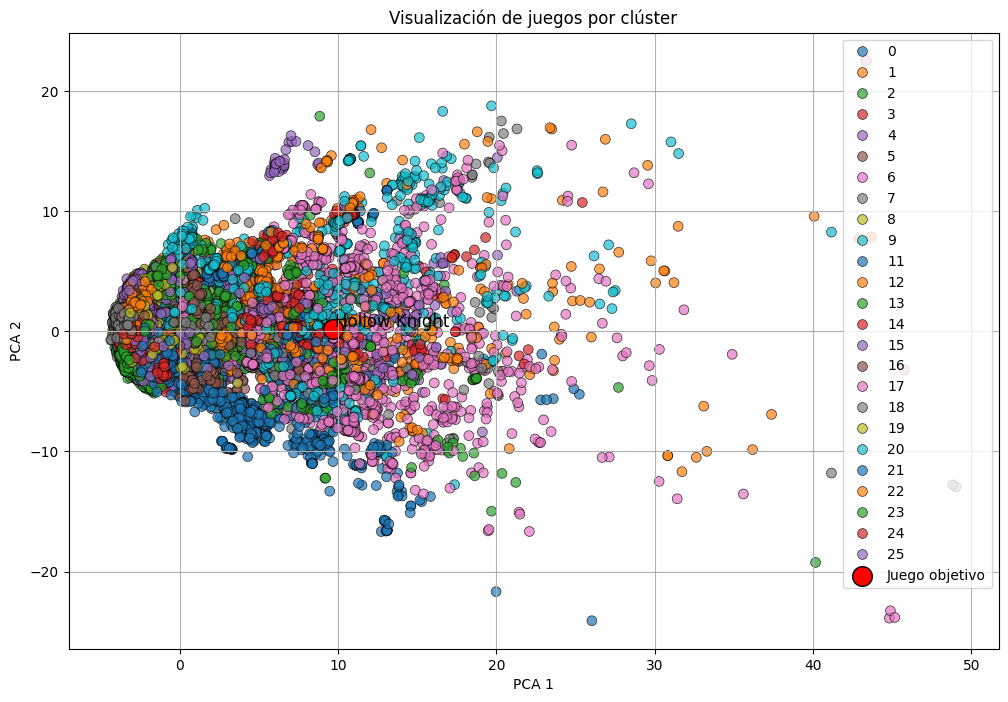

In [16]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Reducir dimensiones a 2D
pca = PCA(n_components=2)
X_2D = pca.fit_transform(X_encoded)

# Crear DataFrame para facilitar el plotting
df_vis = pd.DataFrame({
    'x': X_2D[:, 0],
    'y': X_2D[:, 1],
    'cluster': clusters_dec,
    'nombre': df['name']
})

# Graficar
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df_vis, x='x', y='y', hue='cluster', palette='tab10', s=50, alpha=0.7, edgecolor='k')

# Opcional: destacar un juego específico
nombre_objetivo = "Hollow Knight"
if nombre_objetivo in df['name'].values:
    idx = df.index[df['name'] == nombre_objetivo][0]
    plt.scatter(df_vis.loc[idx, 'x'], df_vis.loc[idx, 'y'], color='red', s=200, label='Juego objetivo', edgecolor='black')
    plt.text(df_vis.loc[idx, 'x']+0.1, df_vis.loc[idx, 'y']+0.1, nombre_objetivo, fontsize=12)

plt.title("Visualización de juegos por clúster")
plt.legend()
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.grid(True)
plt.show()


In [17]:
def evaluar_desempeño_recomendador(juegos_prueba, n_recomendaciones=5):
    """
    Evalúa el desempeño del sistema recomendador usando una métrica ad hoc:
    Coincidencia de géneros y etiquetas entre el juego base y los recomendados.
    """
    total_similitud = 0
    total_evaluados = 0

    for juego in juegos_prueba:
        try:
            recs = recomendar_juegos_por_nombre(juego, n_recomendaciones)
            if not recs:
                continue

            juego_idx = df.index[df['name'] == juego][0]
            tags_obj = set(df.loc[juego_idx, 'tags_list'])
            genres_obj = set(df.loc[juego_idx, 'genres_list'])

            similitudes = []
            for r in recs:
                idx = df[df['name'] == r['nombre']].index[0]
                tags_rec = set(df.loc[idx, 'tags_list'])
                genres_rec = set(df.loc[idx, 'genres_list'])

                jaccard_tags = len(tags_obj & tags_rec) / len(tags_obj | tags_rec) if tags_obj | tags_rec else 0
                jaccard_genres = len(genres_obj & genres_rec) / len(genres_obj | genres_rec) if genres_obj | genres_rec else 0
                score = 0.6 * jaccard_tags + 0.4 * jaccard_genres
                similitudes.append(score)

            promedio = sum(similitudes) / len(similitudes)
            total_similitud += promedio
            total_evaluados += 1

        except:
            continue

    desempeño_global = total_similitud / total_evaluados if total_evaluados else 0
    print(f"Desempeño promedio del recomendador (métrica ad hoc): {desempeño_global:.2f}")


In [18]:
# Lista de juegos del dataset que conoces que existen
juegos_evaluacion = ["Warhammer® 40,000: Dawn of War® - Soulstorm", "Portal 2", "Celeste", "DOOM", "DEFCON"]

evaluar_desempeño_recomendador(juegos_evaluacion)


Desempeño promedio del recomendador (métrica ad hoc): 0.77


Distribución de clústeres:
Clúster 0: 341 elementos
Clúster 1: 1444 elementos
Clúster 2: 524 elementos
Clúster 3: 1479 elementos
Clúster 4: 1193 elementos
Clúster 5: 906 elementos
Clúster 6: 758 elementos
Clúster 7: 4279 elementos
Clúster 8: 1914 elementos
Clúster 9: 312 elementos
Clúster 11: 1084 elementos
Clúster 12: 231 elementos
Clúster 13: 459 elementos
Clúster 14: 3506 elementos
Clúster 15: 1255 elementos
Clúster 16: 510 elementos
Clúster 17: 1347 elementos
Clúster 18: 434 elementos
Clúster 19: 767 elementos
Clúster 20: 927 elementos
Clúster 21: 551 elementos
Clúster 22: 334 elementos
Clúster 23: 1736 elementos
Clúster 24: 344 elementos
Clúster 25: 439 elementos
✅ Total de clústeres presentes: 25 de 26
Generando visualización con t-SNE...


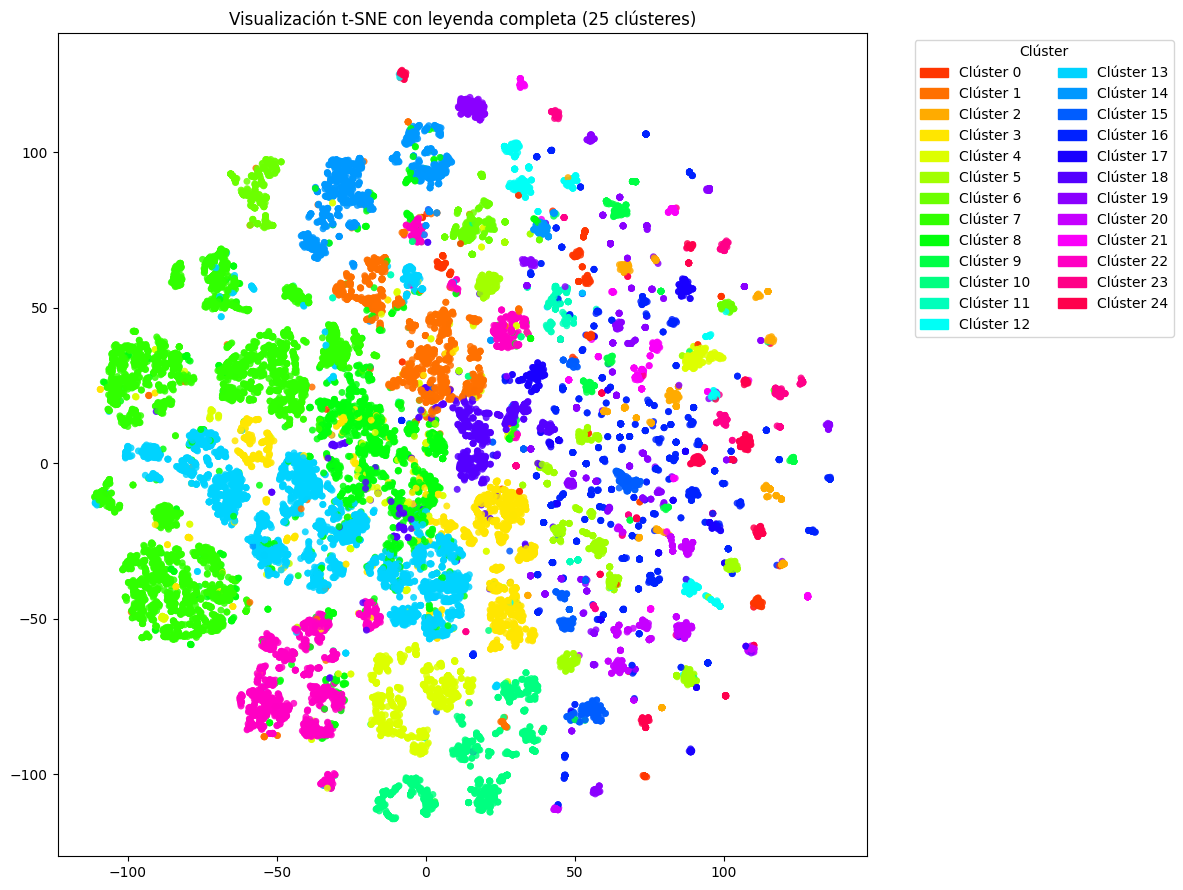

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
from sklearn.manifold import TSNE

# Suponiendo que ya tienes:
# - X_encoded: embeddings codificados
# - clusters_dec: etiquetas de clúster asignadas por DEC
# - k_optimo: cantidad de clústeres usada

# 1. Mostrar cuántos clústeres realmente están presentes
unique, counts = np.unique(clusters_dec, return_counts=True)
print("Distribución de clústeres:")
for cluster_id, count in zip(unique, counts):
    print(f"Clúster {cluster_id}: {count} elementos")
print(f"✅ Total de clústeres presentes: {len(unique)} de {k_optimo}")

# 2. Reducir a 2D con t-SNE (solo una vez)
print("Generando visualización con t-SNE...")
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_2d = tsne.fit_transform(X_encoded)

# 3. Graficar
plt.figure(figsize=(12, 9))
sns.scatterplot(
    x=X_2d[:, 0],
    y=X_2d[:, 1],
    hue=clusters_dec,
    palette=sns.color_palette('hsv', len(unique)),
    s=25,
    alpha=0.85,
    linewidth=0
)

# 4. Leyenda personalizada
palette = sns.color_palette('hsv', len(unique))
legend_patches = [mpatches.Patch(color=palette[i], label=f'Clúster {i}') for i in range(len(unique))]

plt.legend(
    handles=legend_patches,
    title='Clúster',
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    ncol=2
)

plt.title(f'Visualización t-SNE con leyenda completa ({len(unique)} clústeres)')
plt.tight_layout()
plt.show()
